In [ ]:
!pip install prophet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

In [ ]:
data = pd.read_csv('published_task.csv')
data.set_index('PUBLISHED_DATE', inplace=True)
data.head()


,PUBLISHED
PUBLISHED_DATE,
1791-01-01,36
1794-05-01,39
1797-05-01,24
1798-05-01,23
1800-02-01,2


In [ ]:
data.head()

,PUBLISHED
PUBLISHED_DATE,
1791-01-01,36
1794-05-01,39
1797-05-01,24
1798-05-01,23
1800-02-01,2



Checking inavlid or missing values


In [ ]:
data = data.dropna(subset=['PUBLISHED'])
data = data[data.index.notnull()]

Changing the index, If the dataset's index is named PUBLISHED_DATE, it resets the index, turning it into a regular column.

In [ ]:

if 'PUBLISHED_DATE' not in data.columns and data.index.name == 'PUBLISHED_DATE':
    data = data.reset_index()

expected_columns = ['PUBLISHED_DATE', 'PUBLISHED']
data.columns = data.columns.str.strip()  # Remove extra spaces from column names
if list(data.columns) != expected_columns:
    print("Detected inconsistent column names. Standardizing...")
    data = data.rename(columns={data.columns[0]: 'PUBLISHED_DATE', data.columns[1]: 'PUBLISHED'})

Checking whether the data set have parsing error and also the Date is in a correct order

In [ ]:
data['PUBLISHED_DATE'] = pd.to_datetime(data['PUBLISHED_DATE'], errors='coerce')
data = data.sort_values(by='PUBLISHED_DATE')


Renaming the column names for the model

In [ ]:
data.rename(columns={'PUBLISHED_DATE': 'ds', 'PUBLISHED': 'y'}, inplace=True)
data.head()

,ds,y
0,1791-01-01,36
1,1794-05-01,39
2,1797-05-01,24
3,1798-05-01,23
4,1800-02-01,2


In [ ]:
data.tail()

,ds,y
1877,2024-02-01,23234
1878,2024-03-01,27203
1879,2024-04-01,26385
1880,2024-05-01,19134
1881,2024-06-01,19387


In [ ]:
data.set_index('ds', inplace=True)
data.head()

,y
ds,
1791-01-01,36
1794-05-01,39
1797-05-01,24
1798-05-01,23
1800-02-01,2


EDA Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1882 entries, 1791-01-01 to 2024-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       1882 non-null   int64
dtypes: int64(1)
memory usage: 29.4 KB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
y,1882.0,2935.773645,5722.366829,1.0,98.0,352.5,1708.75,30317.0


Text(0.5, 0, 'Years')

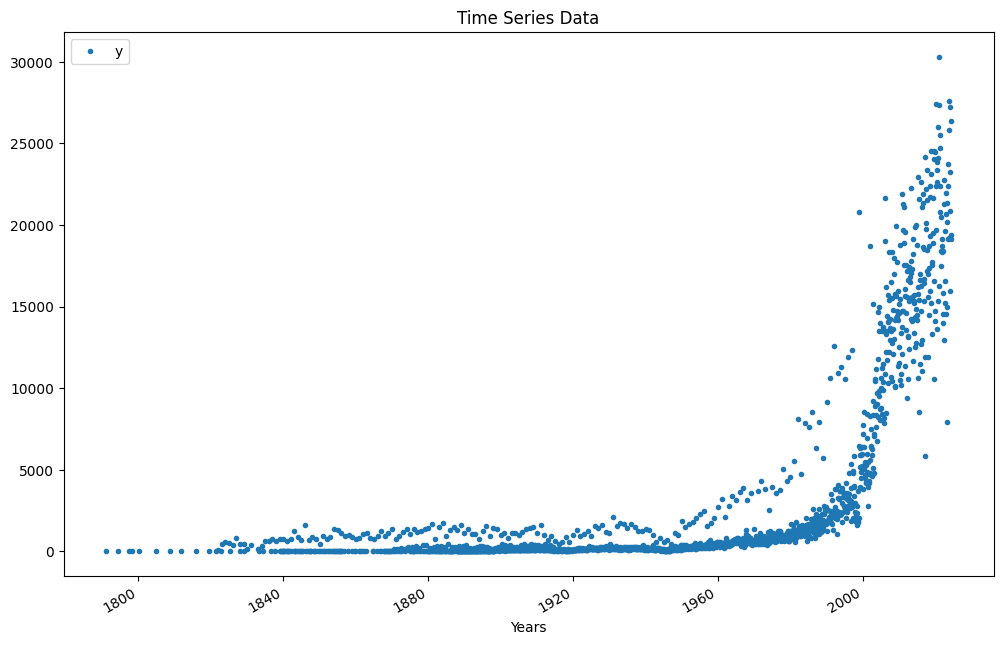

In [ ]:
data.plot(style = '.',figsize=(12, 8))
plt.title('Time Series Data')
plt.xlabel('Years')

In [ ]:
data = data.reset_index()
data.head()

,ds,y
0,1791-01-01,36
1,1794-05-01,39
2,1797-05-01,24
3,1798-05-01,23
4,1800-02-01,2


Split the data set into train and test sets


In [ ]:
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

Using the prophet method to forcasting


In [ ]:
m = Prophet()
m.fit(data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjwm9s2t/wl44anuk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjwm9s2t/fo01q94w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45589', 'data', 'file=/tmp/tmphjwm9s2t/wl44anuk.json', 'init=/tmp/tmphjwm9s2t/fo01q94w.json', 'output', 'file=/tmp/tmphjwm9s2t/prophet_modelp480kkid/prophet_model-20250118112023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=183)
future.tail()

,ds
2060,2024-11-27
2061,2024-11-28
2062,2024-11-29
2063,2024-11-30
2064,2024-12-01


In [ ]:
future = m.make_future_dataframe(periods=183,freq='D')
forecast = m.predict(future)
forecast.tail()



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2060,2024-11-27,22331.692235,20517.854189,24616.222487,22331.692235,22331.692235,83.720012,83.720012,83.720012,83.720012,83.720012,83.720012,0.0,0.0,0.0,22415.412247
2061,2024-11-28,22333.354048,20194.488265,24486.450182,22333.354048,22333.354048,-14.301883,-14.301883,-14.301883,-14.301883,-14.301883,-14.301883,0.0,0.0,0.0,22319.052165
2062,2024-11-29,22335.015860,20132.126475,24305.778366,22335.015860,22335.015860,-81.906976,-81.906976,-81.906976,-81.906976,-81.906976,-81.906976,0.0,0.0,0.0,22253.108885
2063,2024-11-30,22336.677673,20033.196346,24372.723833,22336.677673,22336.677673,-114.479178,-114.479178,-114.479178,-114.479178,-114.479178,-114.479178,0.0,0.0,0.0,22222.198494
2064,2024-12-01,22338.339486,20161.125548,24350.288432,22338.339486,22338.339486,-108.180018,-108.180018,-108.180018,-108.180018,-108.180018,-108.180018,0.0,0.0,0.0,22230.159467


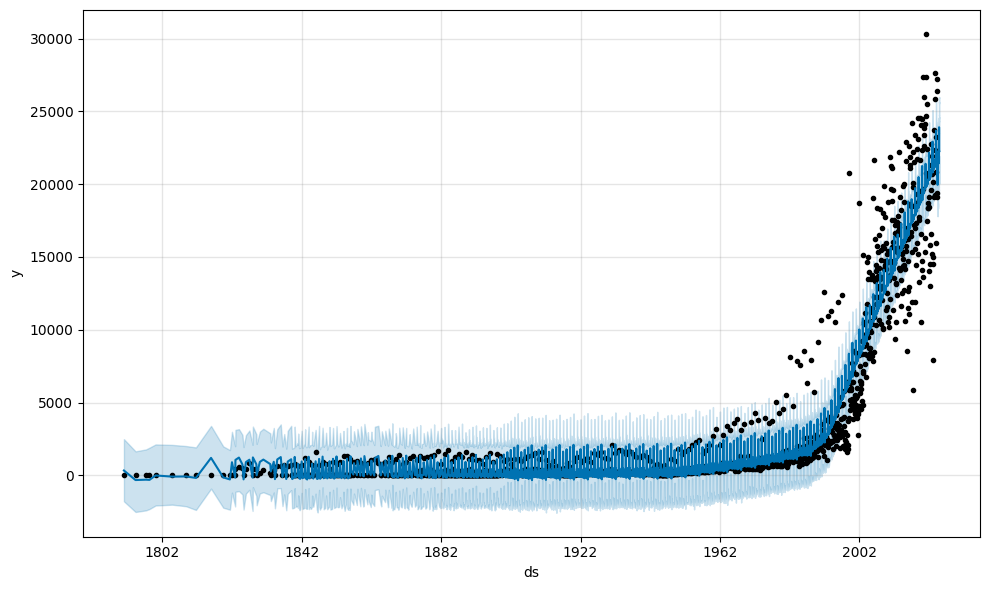

In [ ]:
fig1 = m.plot(forecast)



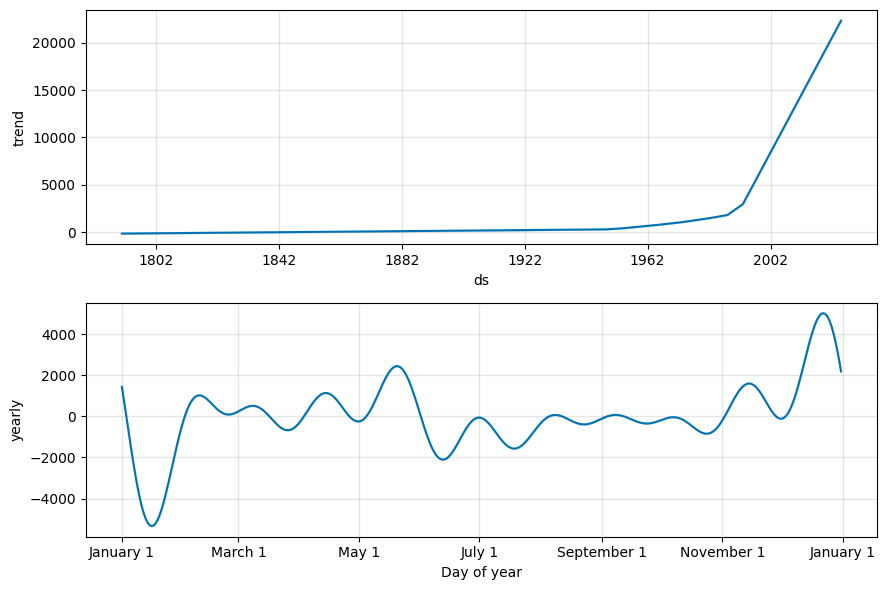

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

Validation Using MSE and R2

In [ ]:

# Extract actuals and predictions for the test period
actuals = test_data['y'].values
predictions = forecast['yhat'][-len(test_data):].values

mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"Validation Mean Squared Error (MSE): {mse}")
print(f"Validation R-squared (R2): {r2}")



Validation Mean Squared Error (MSE): 69891959.46946894
Validation R-squared (R2): -0.5106348739794471


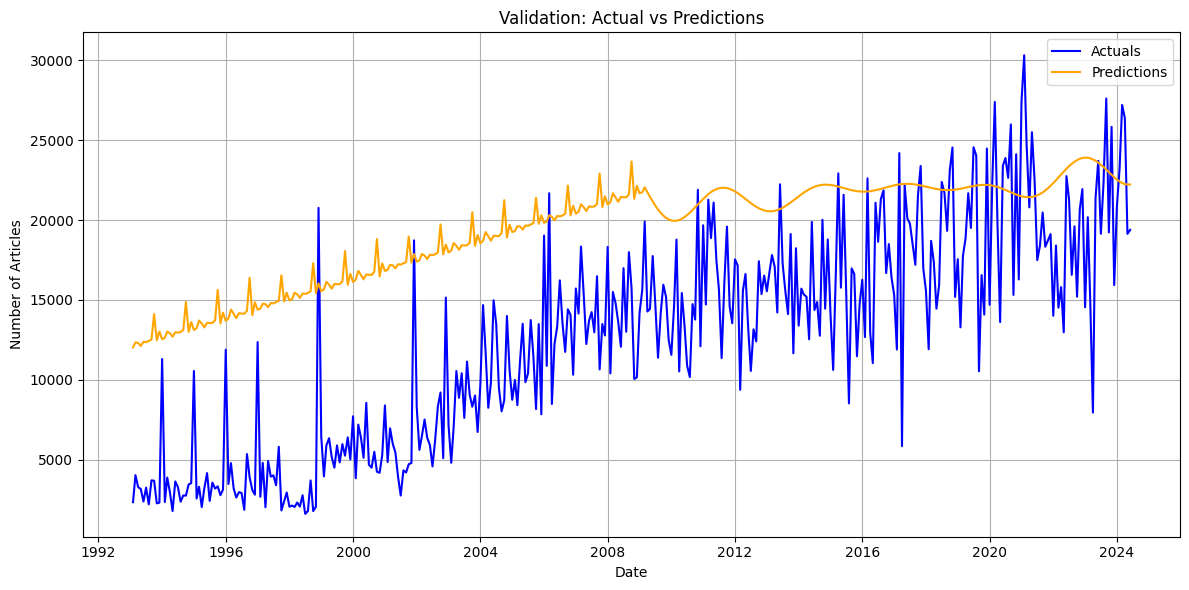

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['ds'], actuals, label='Actuals', color='blue')
plt.plot(test_data['ds'], predictions, label='Predictions', color='orange')
plt.title('Validation: Actual vs Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
data.to_csv("Forcast_Results.csv", index=True)
print(" results saved to 'Forcast_Results.csv'")

 results saved to 'Forcast_Results.csv'
